# Regularized Regression

Lasso, Ridge, and Elastic Net regression are regularized techniques that penalize the size of the coefficients in some form. The purpose of this tutorial is to show how to implement these techniques in sklearn, which can then be compared against the popular R package glmnet. 

## Generating Data

In [28]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
np.random.seed(10)
import pandas as pd
from sklearn import linear_model
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [29]:
def gen_data(n, p, sigma, sparsity):
    mean_array = np.random.randn(p)
    x_data = np.zeros([n, p])
    for var in range(mean_array.shape[0]):
        x_data[:,var] = np.random.normal(mean_array[var], 1, n)
    error = np.random.normal(0, sigma, n)
    beta = np.random.randn(p)
    zero_vars = np.random.choice(p,int(p*sparsity),replace=False)
    beta[zero_vars] = 0
    y_data = np.dot(x_data, beta) + error
    return x_data, y_data, beta

In [30]:
x_data, y_data, beta = gen_data(10000, 5, .1, 0)
#pd.DataFrame(x_data).to_csv('C:\\Users\\smcdo\\OneDrive\\Documents\\Model_Framework\\Benchmarks\\x_data.csv')
#pd.DataFrame(y_data).to_csv('C:\\Users\\smcdo\\OneDrive\\Documents\\Model_Framework\\Benchmarks\\y_data.csv')
pd.DataFrame(x_data).to_csv('C:\\Users\\smcdo\\OneDrive\\Documents\\Model_Framework\\R Practice\\x_data.csv')
pd.DataFrame(y_data).to_csv('C:\\Users\\smcdo\\OneDrive\\Documents\\Model_Framework\\R Practice\\y_data.csv')

In [31]:
x_data = pd.read_csv('C:\\Users\\smcdo\\OneDrive\\Documents\\Model_Framework\\Benchmarks\\x_data.csv', index_col=0)
y_data = pd.read_csv('C:\\Users\\smcdo\\OneDrive\\Documents\\Model_Framework\\Benchmarks\\y_data.csv', index_col=0, squeeze=True)

## Python vs R

There are a few packages in R that calculate regularized regression. The most popular is glmnet, which has an underlying C implementation. This package, while useful, does have a few odd behaviors when it comes to fitting regularized regression. It standardizes the y variable to have zero mean and unit variance, using the formula for population variance (n rather than n-1). Resulting coefficients are then unstandardized. This standardization cannot be turned off, which is especially confusing given that that there is a standardize parameter in the fitting function. This parameter refers to standardization of the x variables (in which case, the coefficients are unstandardized after fitting as well). The penalized package in R does not have this issue. Thus, it is possible to exactly replicate results with the penalized package without standardization.

There are also differences among the packages in terms of the objective function. For scikit-learn ridge regression, the sum of the squared errors is used. For elastic net, one-half of the MSE is used, however there is also a 1/2 factor on the penalty term, so the scale factor is 1/n. R glmnet has the same objective function as Elastic-Net.

Python Ridge Estimator: alpha_ridge

Python Ridge using Elastic-Net: alpha_en = alpha_ridge/nsamps, l1_ratio = 0

R Ridge in glmnet: lambda = alpha_ridge/nsamps = alpha_en, alpha = 0 = l1_ratio

R Ridge in penalized: lambda = alpha_ridge = alpha_en*nsamps

Python Lasso using Elastic-Net: alpha_lasso, l1_ratio = 1

R Lasso in glmnet: lambda = alpha_lasso, alpha = 1 = l1_ratio

R Lasso in penalized: lambda = alpha_lasso*nsamps

None of the three penalize the intercept. 

## Ridge

### Ridge Alpha Fixed

In [3]:
#Ridge brute force, solution is: beta = (X'X+lambda*I)^(-1)X'y
inner = np.dot(x_data.T,x_data)+10*np.diag([1]*x_data.shape[1])
beta = np.dot(np.dot(np.linalg.inv(inner),x_data.T),y_data)
print('Coefficients: %s' % beta)

Coefficients: [ 0.1782607  -0.84166752 -1.30233238  0.1096027  -1.45702562]


In [4]:
#Ridge Exact using Ridge
rm = linear_model.Ridge(alpha=10, fit_intercept=False)
%timeit rm.fit(x_data, y_data)
print('Coefficients: %s' % rm.coef_)

1000 loops, best of 3: 627 µs per loop
Coefficients: [ 0.1782607  -0.84166752 -1.30233238  0.1096027  -1.45702562]


In [5]:
#Ridge Exact Using Elastic Net
nsamps = x_data.shape[0]
rm = linear_model.ElasticNet(l1_ratio=0, alpha=1.212779, fit_intercept=False, max_iter=10000)
%timeit rm.fit(x_data, y_data)
print('Coefficients: %s' % rm.coef_)

1 loop, best of 3: 2.22 s per loop
Coefficients: [ 0.15403289 -0.34102672 -0.6809968   0.0494305  -0.62872913]


### Ridge CV

In [8]:
alphas = np.logspace(-10, 5, 100)
rm = linear_model.RidgeCV(fit_intercept=False, alphas=alphas)
%timeit rm.fit(x_data, y_data)
print('Coefficients: %s' % rm.coef_)
print('CV Alpha: %s' % rm.alpha_)
print('CV Alpha in glmnet terms: %s' % (rm.alpha_/nsamps))

10 loops, best of 3: 27.8 ms per loop
Coefficients: [ 0.1782825  -0.8425946  -1.30342461  0.10971409 -1.45853887]
CV Alpha: 0.0107226722201
CV Alpha in glmnet terms: 1.07226722201e-06


### Model Framework Implementation

10 loops, best of 3: 30.2 ms per loop
Coefficients: 0            0.175890
1           -0.848374
2           -1.298150
3            0.109983
4           -1.465754
intercept    0.000000
Name: coefficients, dtype: float64
CV Alpha: 0.705480231072


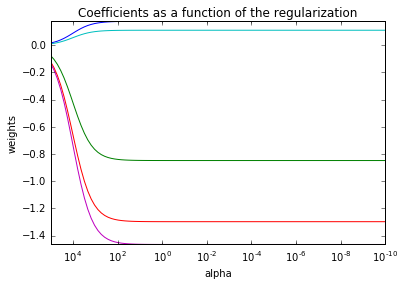

In [14]:
import Machine_Learning_Interface.regularized_regression as rr
model = rr.RidgeRegression(intercept=False, cv_folds=None, solver='svd', scale=True)
%timeit model.fit(pd.DataFrame(x_data), y_data)
model.diagnostics()
print('Coefficients: %s' % model.coefs)
print('CV Alpha: %s' % model.model.alpha_)

## Lasso

In [15]:
#Lasso using regular Lasso
rm = linear_model.Lasso(alpha=1, fit_intercept=False)
%timeit rm.fit(x_data, y_data)
print('Coefficients: %s' % rm.coef_)

The slowest run took 21.16 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.23 ms per loop
Coefficients: [ 0.         -0.         -0.54385611  0.         -0.3760401 ]


In [16]:
#Lasso using Elastic Net
nsamps = x_data.shape[0]
rm = linear_model.ElasticNet(l1_ratio=1, alpha=1.0, fit_intercept=False)
%timeit rm.fit(x_data, y_data)
print('Coefficients: %s' % rm.coef_)

1000 loops, best of 3: 1.17 ms per loop
Coefficients: [ 0.         -0.         -0.54385611  0.         -0.3760401 ]


In [17]:
#Lasso using LARS
rm = linear_model.LassoLars(alpha=1, fit_intercept=False)
%timeit rm.fit(x_data, y_data)
print('Coefficients: %s' % rm.coef_)

The slowest run took 63.75 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 757 µs per loop
Coefficients: [ 0.          0.         -0.54386026  0.         -0.37604292]


### Lasso CV

In [18]:
#Lasso CV Coordinate Descent
rm = linear_model.LassoCV(fit_intercept=False, cv=5, selection='cyclic')
%timeit rm.fit(x_data, y_data)
print('Coefficients: %s' % rm.coef_)
print('CV Alpha: %s' % rm.alpha_)

10 loops, best of 3: 92 ms per loop
Coefficients: [ 0.1765783  -0.8397282  -1.30200453  0.10725175 -1.45561405]
CV Alpha: 0.00248538897779


In [19]:
#Lasso CV Lars
rm = linear_model.LassoLarsCV(fit_intercept=True, cv=5)
%timeit rm.fit(x_data, y_data)
print('Coefficients: %s' % rm.coef_)
print('CV Alpha: %s' % rm.alpha_)

The slowest run took 5.98 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 16.5 ms per loop
Coefficients: [ 0.17773187 -0.84289583 -1.30278712  0.10972621 -1.45880093]
CV Alpha: 0.0


### Machine Learning Interface

10 loops, best of 3: 90.3 ms per loop


C:\Users\smcdo\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\smcdo\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\smcdo\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\smcdo\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\smcdo\Anaconda2\lib\site-pa

Coefficients: 0            0.174453
1           -0.846969
2           -1.296835
3            0.108538
4           -1.464350
intercept    0.000000
Name: coefficients, dtype: float64
CV Alpha: 0.00146972797522


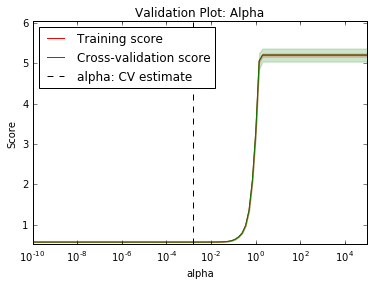

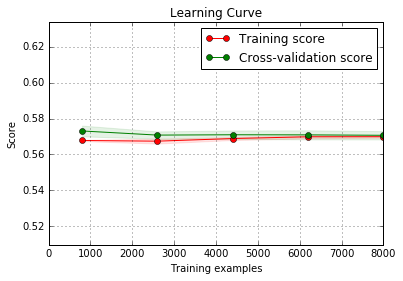

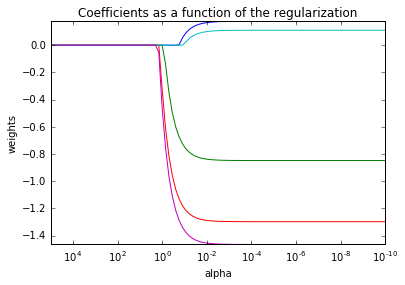

In [21]:
import Machine_Learning_Interface.regularized_regression as rr
model = rr.LassoRegression(intercept=False, cv_folds=5, solver='Coordinate Descent', scale=True)
%timeit model.fit(pd.DataFrame(x_data), pd.Series(y_data))
model.diagnostics()
print('Coefficients: %s' % model.coefs)
print('CV Alpha: %s' % model.model.alpha_)

## Elastic Net

In [25]:
#Elastic Net 50/50
nsamps = x_data.shape[0]
rm = linear_model.ElasticNet(l1_ratio=.5, alpha=1.0, fit_intercept=False, max_iter=10000)
%timeit rm.fit(x_data, y_data)
print('Coefficients: %s' % rm.coef_)

1000 loops, best of 3: 1.28 ms per loop
Coefficients: [ 0.         -0.16097752 -0.69771119  0.         -0.58107577]


### Elastic Net CV

In [26]:
nsamps = x_data.shape[0]
rm = linear_model.ElasticNetCV(l1_ratio=.5, fit_intercept=False)
%timeit rm.fit(x_data, y_data)
print('Coefficients: %s' % rm.coef_)
print('CV Alpha: %s' % model.model.alpha_)

10 loops, best of 3: 77.7 ms per loop
Coefficients: [ 0.17652873 -0.83743177 -1.2992934   0.10698108 -1.45186232]
CV Alpha: 0.00146972797522


### Machine Learning Interface

10 loops, best of 3: 92.6 ms per loop


C:\Users\smcdo\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\smcdo\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\smcdo\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\smcdo\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\smcdo\Anaconda2\lib\site-pa

Coefficients: 0            0.174199
1           -0.845710
2           -1.294981
3            0.108379
4           -1.462206
intercept    0.000000
Name: coefficients, dtype: float64
CV Alpha: 0.00293945595044


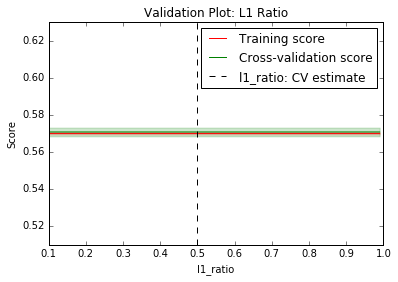

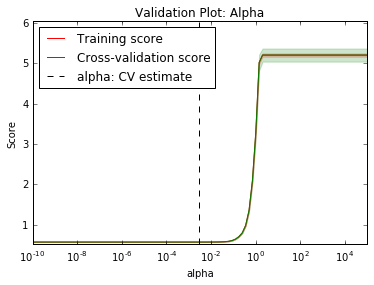

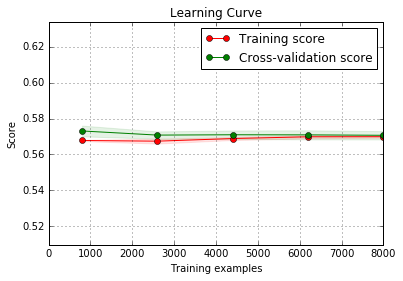

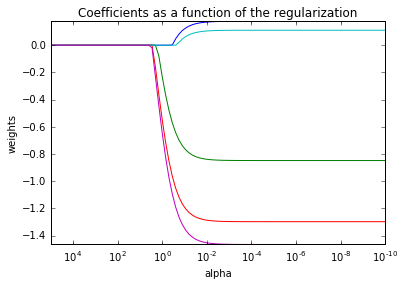

In [27]:
import Machine_Learning_Interface.regularized_regression as rr
model = rr.ElasticNetRegression(intercept=False, cv_folds=5, solver='Coordinate Descent', scale=True)
%timeit model.fit(pd.DataFrame(x_data), pd.Series(y_data))
model.diagnostics()
print('Coefficients: %s' % model.coefs)
print('CV Alpha: %s' % model.model.alpha_)